In [1]:

import numpy as np
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
from keras import optimizers
from keras.layers import Input
from keras.models import Model
from keras.layers import Dense, Reshape
from keras.layers import Convolution1D, MaxPooling1D, BatchNormalization
from keras.layers import Lambda, concatenate
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
#from keras.utils import np_utils
import h5py


def mat_mul(A, B):
    return tf.matmul(A, B)


def exp_dim(global_feature, num_points):
    return tf.tile(global_feature, [1, num_points, 1])


def load_h5(h5_filename):
    f = h5py.File(h5_filename)
    data = f['data'][:]
    label = f['label'][:]
    return (data, label)


def rotate_point_cloud(batch_data):
    rotated_data = np.zeros(batch_data.shape, dtype=np.float32)
    for k in range(batch_data.shape[0]):
        rotation_angle = np.random.uniform() * 2 * np.pi
        cosval = np.cos(rotation_angle)
        sinval = np.sin(rotation_angle)
        rotation_matrix = np.array([[cosval, 0, sinval],
                                    [0, 1, 0],
                                    [-sinval, 0, cosval]])
        shape_pc = batch_data[k, ...]
        rotated_data[k, ...] = np.dot(shape_pc.reshape((-1, 3)), rotation_matrix)
    return rotated_data

def jitter_point_cloud(batch_data, sigma=0.01, clip=0.05):
    B, N, C = batch_data.shape
    assert(clip > 0)
    jittered_data = np.clip(sigma * np.random.randn(B, N, C), -1 * clip, clip)
    jittered_data += batch_data
    return jittered_data

Using TensorFlow backend.


In [2]:
# number of points in each sample
num_points = 1024
# number of categories
k = 4
# epoch number
epo = 50
# define optimizer
adam = optimizers.Adam(lr=0.001, decay=0.7)

'''
Pointnet Architecture
'''
# input_Transformation_net
input_points = Input(shape=(num_points, 3))
x = Convolution1D(64, 1, activation='relu',
                  input_shape=(num_points, 3))(input_points)
x = BatchNormalization()(x)
x = Convolution1D(128, 1, activation='relu')(x)
x = BatchNormalization()(x)
x = Convolution1D(1024, 1, activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=num_points)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(9, weights=[np.zeros([256, 9]), np.array([1, 0, 0, 0, 1, 0, 0, 0, 1]).astype(np.float32)])(x)
input_T = Reshape((3, 3))(x)

# forward net
g = Lambda(mat_mul, arguments={'B': input_T})(input_points)
g = Convolution1D(64, 1, input_shape=(num_points, 3), activation='relu')(g)
g = BatchNormalization()(g)
g = Convolution1D(64, 1, input_shape=(num_points, 3), activation='relu')(g)
g = BatchNormalization()(g)

# feature transformation net
f = Convolution1D(64, 1, activation='relu')(g)
f = BatchNormalization()(f)
f = Convolution1D(128, 1, activation='relu')(f)
f = BatchNormalization()(f)
f = Convolution1D(1024, 1, activation='relu')(f)
f = BatchNormalization()(f)
f = MaxPooling1D(pool_size=num_points)(f)
f = Dense(512, activation='relu')(f)
f = BatchNormalization()(f)
f = Dense(256, activation='relu')(f)
f = BatchNormalization()(f)
f = Dense(64 * 64, weights=[np.zeros([256, 64 * 64]), np.eye(64).flatten().astype(np.float32)])(f)
feature_T = Reshape((64, 64))(f)

# forward net
g = Lambda(mat_mul, arguments={'B': feature_T})(g)
seg_part1 = g
g = Convolution1D(64, 1, activation='relu')(g)
g = BatchNormalization()(g)
g = Convolution1D(128, 1, activation='relu')(g)
g = BatchNormalization()(g)
g = Convolution1D(1024, 1, activation='relu')(g)
g = BatchNormalization()(g)

# global_feature
global_feature = MaxPooling1D(pool_size=num_points)(g)
global_feature = Lambda(exp_dim, arguments={'num_points': num_points})(global_feature)

# point_net_seg
c = concatenate([seg_part1, global_feature])
c = Convolution1D(512, 1, activation='relu')(c)
c = BatchNormalization()(c)
c = Convolution1D(256, 1, activation='relu')(c)
c = BatchNormalization()(c)
c = Convolution1D(128, 1, activation='relu')(c)
c = BatchNormalization()(c)
c = Convolution1D(128, 1, activation='relu')(c)
c = BatchNormalization()(c)
prediction = Convolution1D(k, 1, activation='softmax')(c)
'''
end of pointnet
'''

# define model
model = Model(inputs=input_points, outputs=prediction)
print(model.summary())


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1024, 3)      0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1024, 3)      0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 1024, 64)     256         lambda_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_6 (BatchNor (None, 1024, 64)     256         conv1d_4[0][0]                   
__________________________________________________________________________________________________
conv1d_5 (

In [3]:
# compile classification model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [4]:
# load weights from pre-trained pointnet model
model.load_weights('seg_epooch_50.h5')

In [7]:
pwd

'/data/home/zeno/shape_data/pointnet'

In [8]:
# load TEST points and labels
test_path = os.path.join('/data/home/zeno/shape_data/pointnet', "Seg_Prep_test")
filenames = [d for d in os.listdir(test_path)]
print(test_path)
print(filenames)
test_points = None
test_labels = None
for d in filenames:
    cur_points, cur_labels = load_h5(os.path.join(test_path, d))
    if test_labels is None or test_points is None:
        test_labels = cur_labels
        test_points = cur_points
    else:
        test_labels = np.hstack((test_labels, cur_labels))
        test_points = np.hstack((test_points, cur_points))
test_points_r = test_points.reshape(-1, num_points, 3)
test_labels_r = test_labels.reshape(-1, num_points, k)

/data/home/zeno/shape_data/pointnet/Seg_Prep_test
['Airplane.h5']


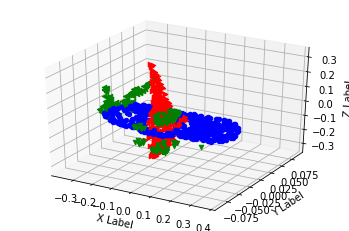

In [9]:
%matplotlib inline
# select one test data to visualize
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
v_points = test_points_r[1:2,:,:]
pred = model.predict(v_points)
pred = np.squeeze(pred)
v_points = np.squeeze(v_points)
pred = pred.tolist()
color = ['b', 'g', 'g', 'r']
m= ['o', 'v', '<', '>']
for i in range(v_points.shape[0]):
    xs = v_points[i,0]
    ys = v_points[i,1]
    zs = v_points[i,2]
    ind = pred[i].index(max(pred[i]))
    ax.scatter(xs, ys, zs, c=color[ind], marker=m[ind])

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()